## Import dataloader

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from get_data import get_dataset
from data._data_static import TEGNINGER

In [2]:
train_loader, val_loader = get_dataset(
    names=TEGNINGER,
    n_samples=1000,
    batch_size=64,
    verbose=False,
)

train_loader.batch_size, len(train_loader.dataset), len(train_loader)

(64, 3612267, 16)

## Confirm (visually) that the labels and images are still in correct pairs

In [3]:
def plot_figure(images: torch.Tensor, labels: torch.Tensor, ns: torch.Tensor) -> None:
    """
    Plot a grid of images with their corresponding labels.
    Args:
        images (torch.Tensor): A tensor of images.
        labels (torch.Tensor): A tensor of labels.
        ns (int): The number of rows and columns in the grid.

    Returns:
        None
    """
    # Define the figure
    fig, ax = plt.subplots(figsize=(14, 14), nrows=ns, ncols=ns)
    for i in range(ns):
        for j in range(ns):
            # Plot the (i*ns +j)th image
            ax[i, j].imshow(images[i*ns+j].reshape((28, 28)).numpy(), cmap="Greys")
            ax[i, j].set_title(TEGNINGER[int(labels[i*ns+j].item())])
            ax[i, j].axis('off')
    # Show the plot
    plt.show()

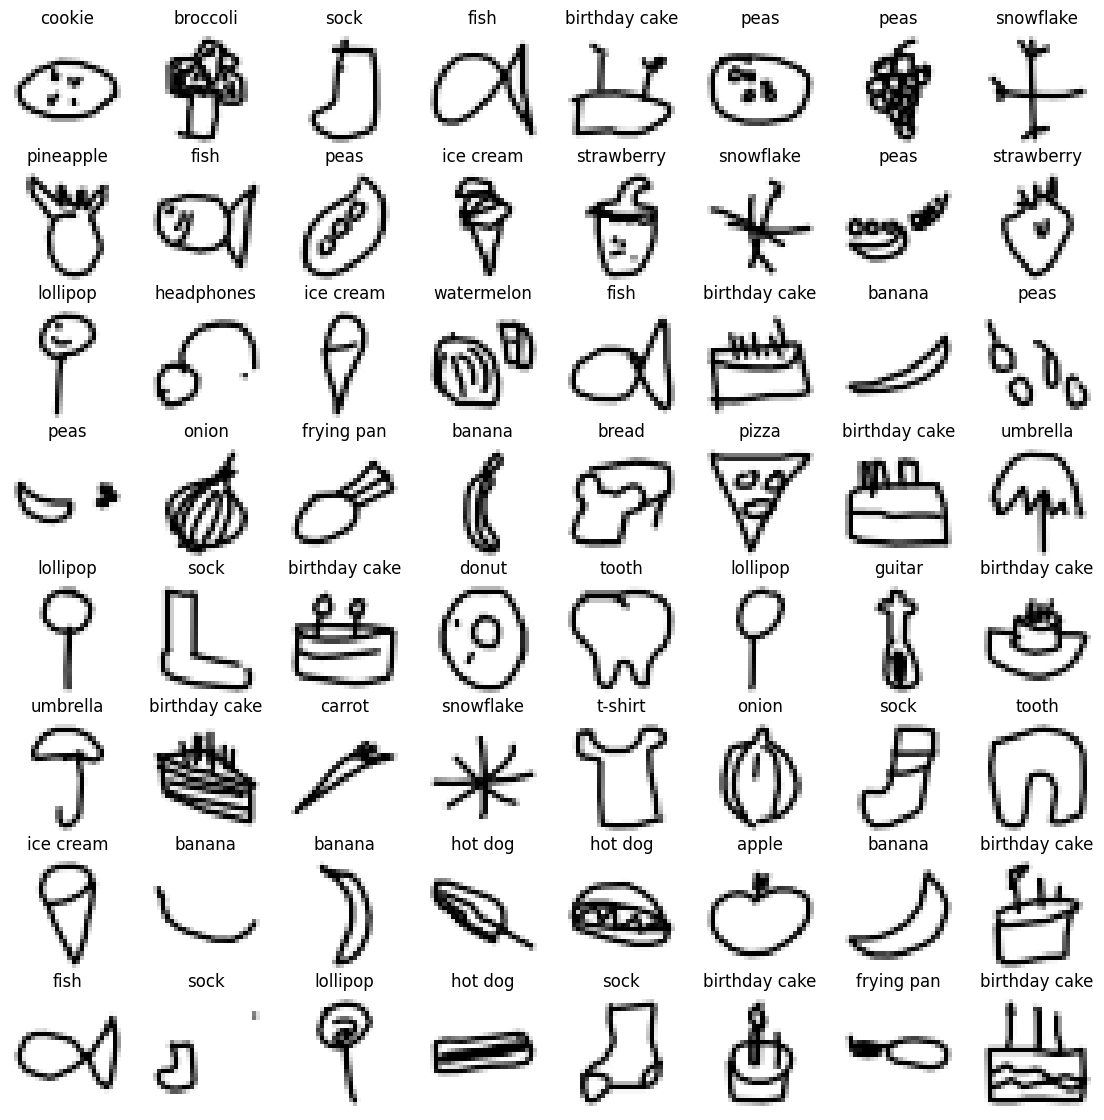

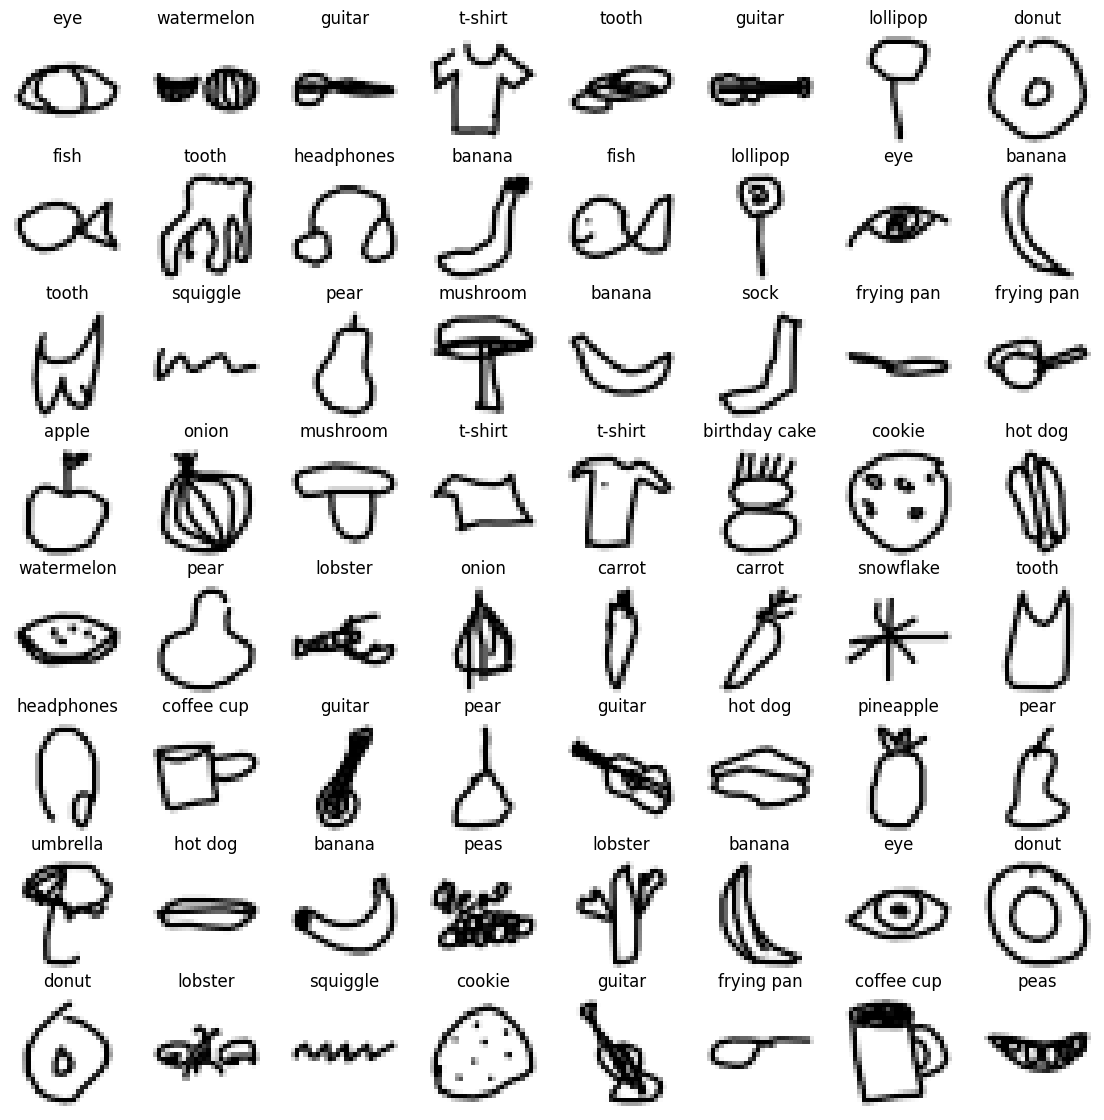

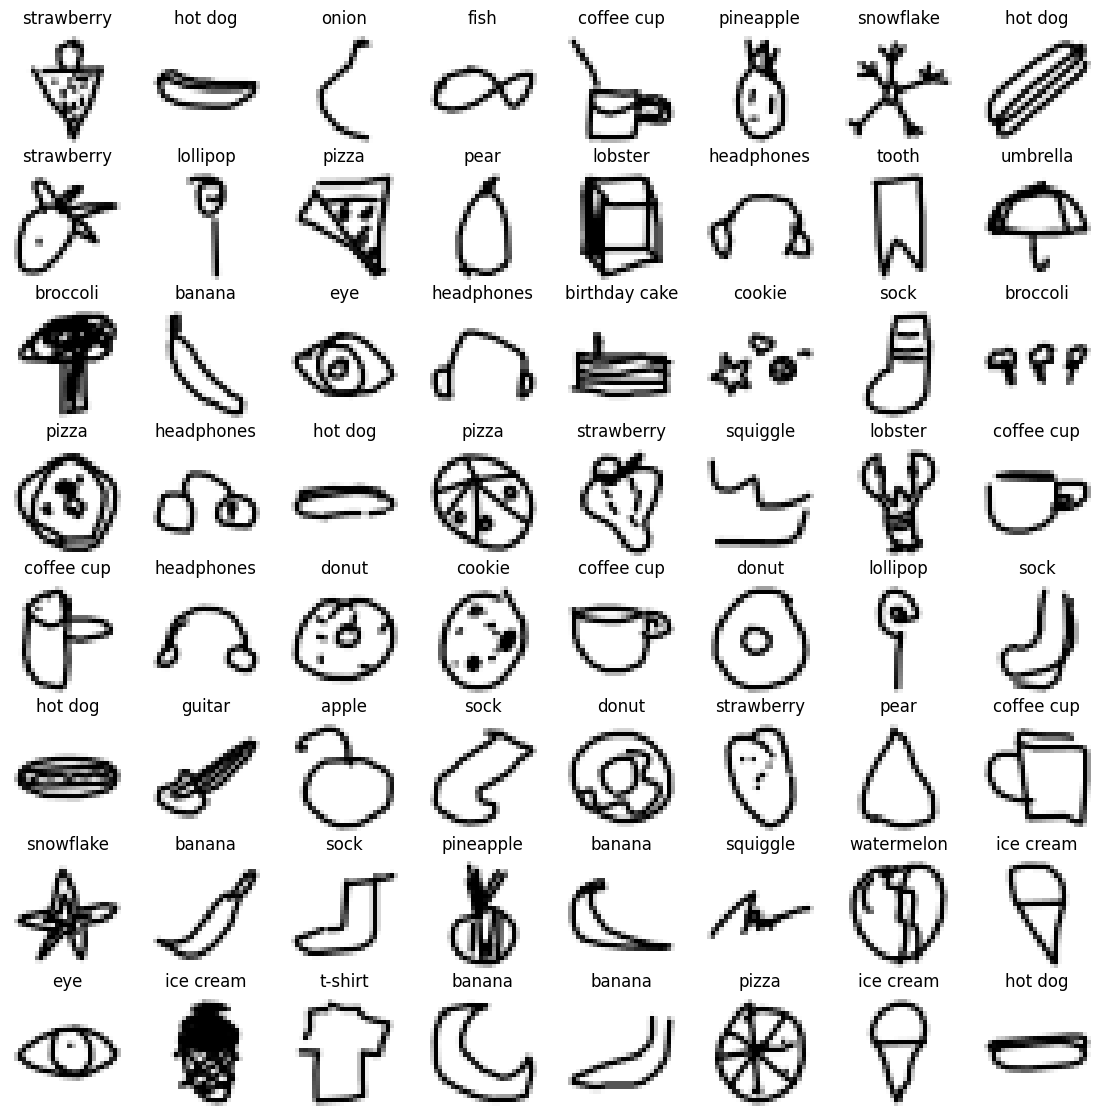

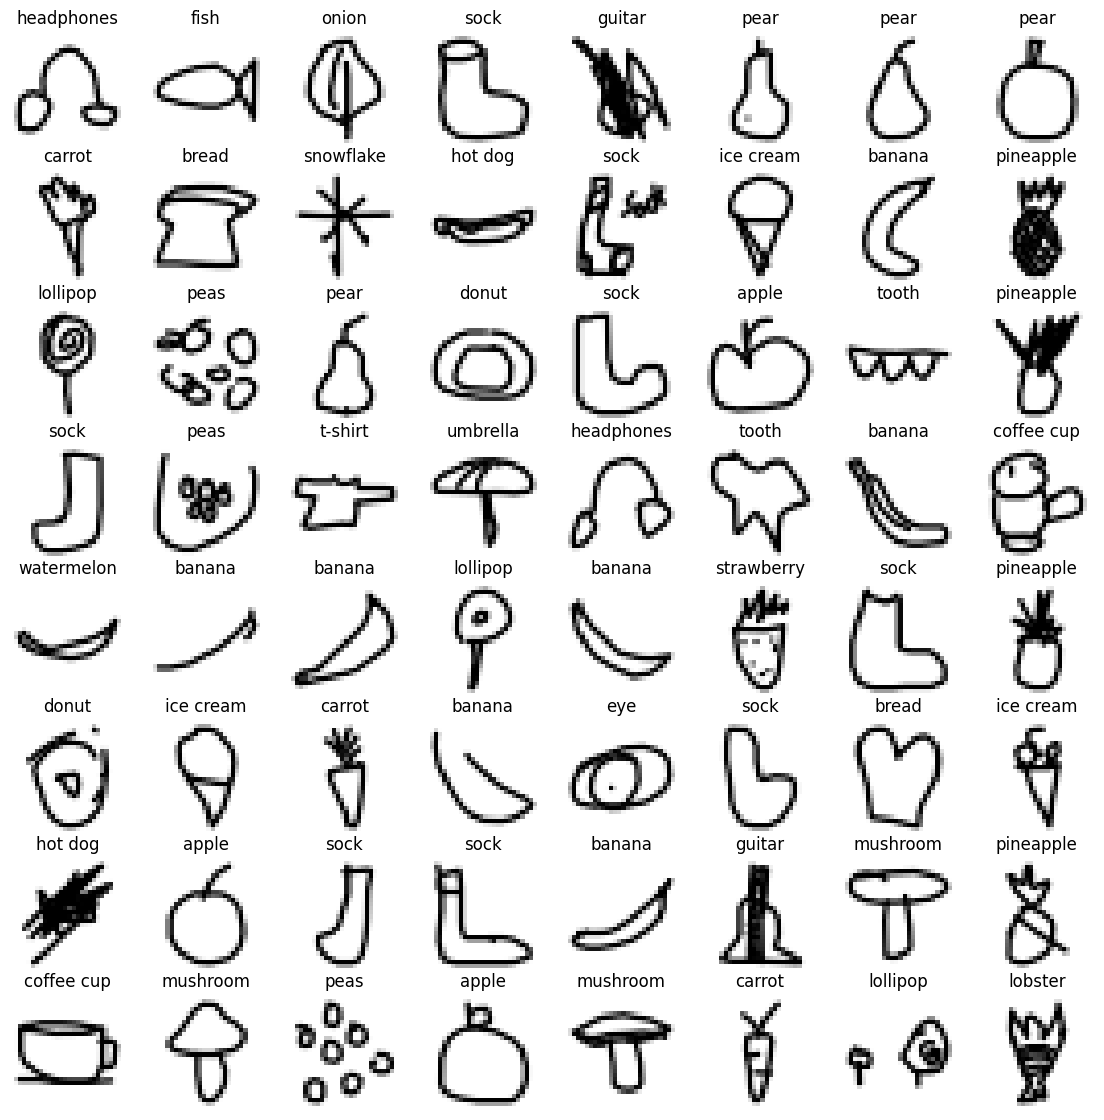

In [4]:
# Loop batches 0, 1, 2, 3
for b, (image, label) in enumerate(train_loader):
    # Plot the figure
    plot_figure(image, label, 8)
    
    # Break if b > 2
    if b > 2:
        break

## Get the distribution of labels in the full train set (confirm stratification)

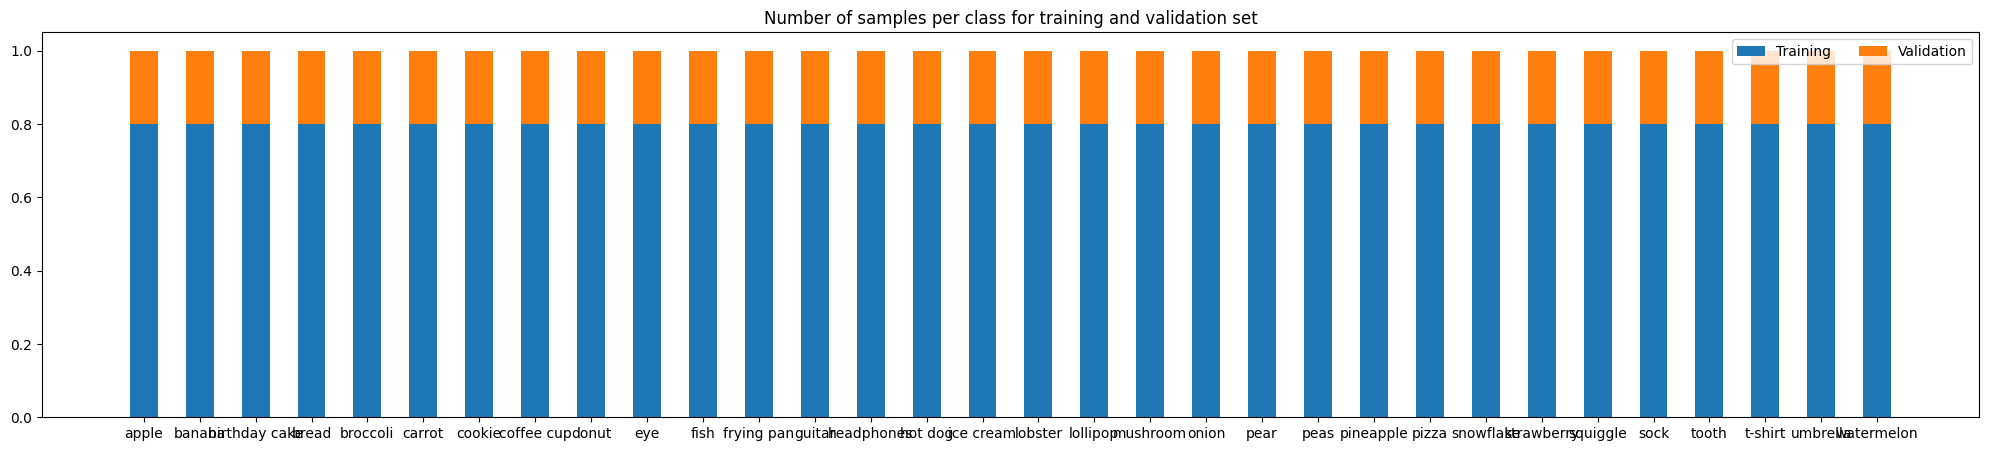

In [17]:
# Pull the full datasets out of the loaders
X_train = train_loader.dataset.tensors[0]
y_train = train_loader.dataset.tensors[1]

X_val = val_loader.dataset.tensors[0]
y_val = val_loader.dataset.tensors[1]

# Count the number of samples per class in the training and validation set
dist = {
    label: [
        sum(y == i).item() for i, tegninger in enumerate(TEGNINGER)
    ] for label, y in zip(["Training", "Validation"], [y_train, y_val])
}

# Normalize the counts so that the two distributions sum to 1 for each class
norm_dist = {
    "Training": [
        dist["Training"][i] / (dist["Training"][i] + dist["Validation"][i])
        for i in range(len(TEGNINGER))
    ],
    "Validation": [
        dist["Validation"][i] / (dist["Training"][i] + dist["Validation"][i])
        for i in range(len(TEGNINGER))
    ],
}

# Plot the distribution as a stacked bar chart
fig, ax = plt.subplots(figsize=(25, 5))
bottom = np.zeros(len(list(norm_dist.values())[0]))

x = TEGNINGER
width = 0.5

for label, count in norm_dist.items():
    ax.bar(x, count, width, label=label, bottom=bottom)
    bottom += count
ax.set_title("Number of samples per class for training and validation set")
ax.legend(ncol=2, loc="upper right")
plt.show()

## The distribution of labels across different batches in an epoch

In [ ]:
def get_dist(loader, by: str = "batch"):
    """
    Get the distribution of samples per class per batch or per batch per class.
    Args:
        loader (torch.utils.data.DataLoader): The data loader.
        by (str): The distribution type. Either "batch" or "tegning".
    
    Returns:
        dist (dict): The distribution.
    """
    if by == "batch":
        # Initialize the distribution
        dist = {f"Batch {e}": np.zeros(len(TEGNINGER)) for e in range(len(loader))}
        # Loop over the batches
        for e, (_, labels) in enumerate(loader):
            for label in labels:
                # Update the distribution
                dist[f"Batch {e}"][int(label)] += 1
            
    elif by == "tegning":
        # Initialize the distribution
        dist = {TEGNINGER[i]: np.zeros(len(loader)) for i in range(len(TEGNINGER))}
        # Loop over the batches
        for e, (_, labels) in enumerate(loader):
            for label in labels:
                # Update the distribution
                dist[TEGNINGER[int(label)]][e] += 1
                
    return dist

def plot_dist(loader = train_loader, by: str = "batch", width: int = 0.5):
    """
    Plot the distribution of samples per class per batch or per batch per class.
    Args:
        loader (torch.utils.data.DataLoader): The data loader.
        by (str): The distribution type. Either "batch" or "tegning".
        width (int): The width of the bars.

    Returns:
        None
    """
    # Get the distribution
    dist = get_dist(loader, by)

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(15, 5))
    bottom = np.zeros(len(list(dist.values())[0]))

    # Set the x-axis
    if by == "batch":
        x = TEGNINGER
    else:
        x = [f"Batch {e}" for e in range(len(loader))]

    # Plot the distribution
    for label, count in dist.items():
        ax.bar(x, count, width, label=label, bottom=bottom)
        bottom += count
    ax.set_title("Number of samples per class per batch")
    ax.legend(ncol=8, loc="upper right")
    plt.show()

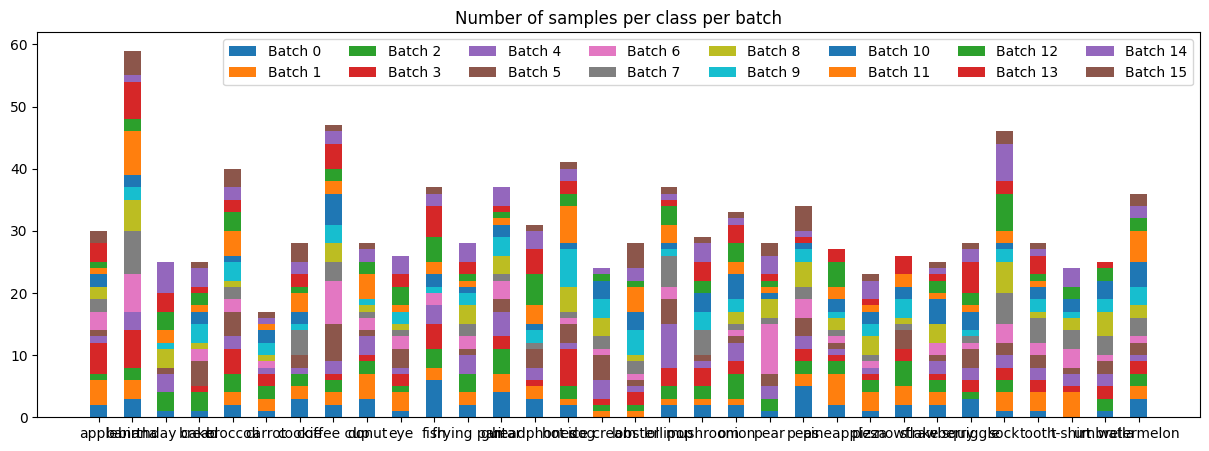

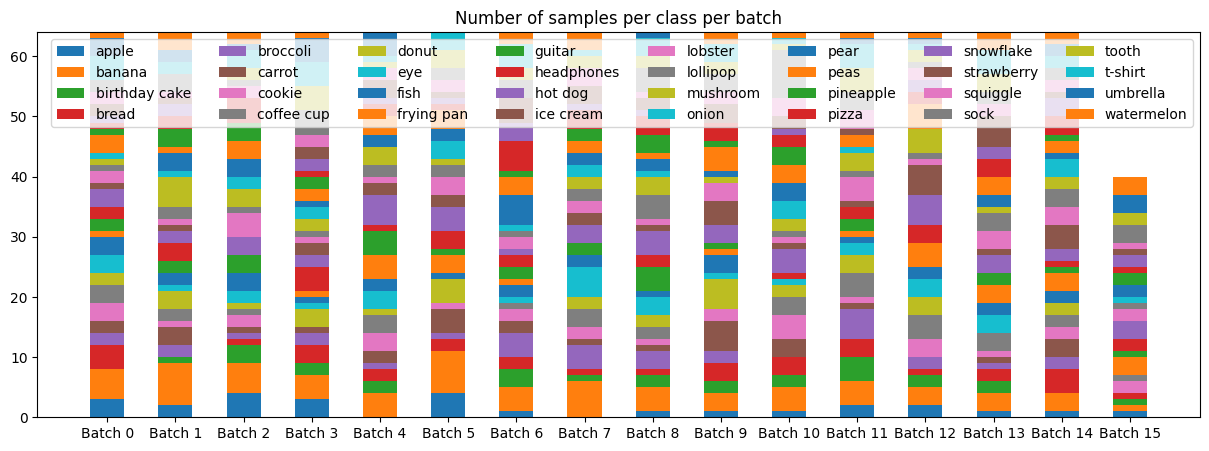

In [ ]:
plot_dist(train_loader, "batch")
plot_dist(train_loader, "tegning")

## Does the distribution of labels across different batches change across different epochs?

In [ ]:
print("Are the distributions the same across epochs?")

def are_dicts_equal(dict1, dict2):
    """
    Check if two dictionaries are equal.
    Args:
        dict1 (dict): The first dictionary.
        dict2 (dict): The second dictionary.
    
    Returns:
        bool: True if the dictionaries are equal, False otherwise
    """
    if set(dict1.keys()) != set(dict2.keys()):
        # If the keys are not the same, the dictionaries are not equal
        return False
    
    for key in dict1.keys():
        # Loop through the keys and check if the values are the same
        if not np.all(dict1[key] == dict2[key]):
            # If the values are not the same, the dictionaries are not equal
            return False
    return True

# Get the distributions for 100 epochs (sample the data 100 times)
dists = []
for e in range(100):
    train_dist = get_dist(train_loader, "batch")
    dists.append(train_dist)

# check if all distributions are different
same_dist = False
for i in range(len(dists)-1):
    for j in range(i+1, len(dists)):
        if are_dicts_equal(dists[i],dists[j]):
            print("Same distribution found for epoch", i, "and", j)
            same_dist = True
            break

if not same_dist:    
    print("All distributions are different")

Are the distributions the same across epochs?
All distributions are different
